core           INFO 	Loading data for Italian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '4', '55', '44', '1', '63', '11', '23', '20', '14', '43', '3', '31', '10', '77', '27', '24', '18', '22']
c:\Users\dilau\Desktop\TeamProjF1\fasftF1\.venv\Lib\site-pack

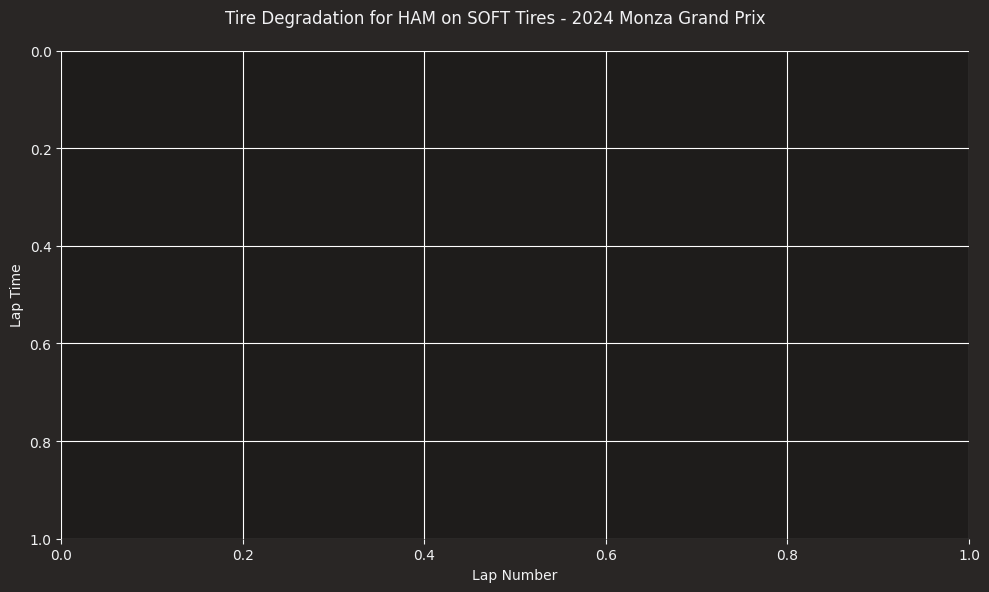

In [2]:
import seaborn as sns
import fastf1
import fastf1.plotting
from matplotlib import pyplot as plt

# Enable cache (optional)
# fastf1.Cache.enable_cache('cache')

# Set up FastF1 and Matplotlib
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False, color_scheme='fastf1')

# Define the session details
year = 2024
gran_prix = "Monza"
sessionG = 'R'  # Race session
driver = "HAM"  # Driver to analyze
compound = "SOFT"  # Tire compound to analyze

# Load the race session
session = fastf1.get_session(year, gran_prix, sessionG)
session.load()

# Get all laps for the specified driver and tire compound
driver_laps = session.laps.pick_driver(driver).pick_tyre(compound).pick_quicklaps().reset_index()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot lap times over the stint
sns.scatterplot(
    data=driver_laps,
    x="LapNumber",
    y="LapTime",
    ax=ax,
    color=fastf1.plotting.get_compound_color(compound, session=session),  # Use compound color
    s=80,
    linewidth=0,
    label=f"{driver} - {compound}"
)

# Add a trendline to visualize degradation
sns.regplot(
    data=driver_laps,
    x="LapNumber",
    y="LapTime",
    ax=ax,
    scatter=False,
    color='red',
    line_kws={"linestyle": "--", "label": "Trendline"}
)

# Customize the plot
ax.set_xlabel("Lap Number")
ax.set_ylabel("Lap Time")
ax.invert_yaxis()  # Invert y-axis for better visualization of lap times
plt.suptitle(f"Tire Degradation for {driver} on {compound} Tires - {year} {gran_prix} Grand Prix")

# Add grid and improve layout
plt.grid(color='w', which='major', axis='both')
sns.despine(left=True, bottom=True)
plt.tight_layout()

# Show the plot
plt.show()